In [2]:
import numpy as np
import pandas as pd
from IPython.display import display 
from sklearn.model_selection import train_test_split
from numpy.random import seed

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)

df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']

display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [47]:
class AdaMiniBatchGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    batch_size : int
        mini_batch size
        
    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    
    def __init__(self, batch_size = 1, eta = 0.01, n_iter = 50, shuffle = True, random_state = 1):
        
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.m = batch_size
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
                
            cost = []
            mini_batches = self.mini_batch(X, y)
            for i in range(len(mini_batches)): 
                batch_i = mini_batches[i][0]
                targets = mini_batches[i][1]
                cost.append(self._update_weights(batch_i, targets))
            avg_cost = sum(cost) / len(mini_batches)
            self.cost_.append(avg_cost)
            
        return self
                      
            
    def mini_batch(self, X, y):    
        if len(y) % self.m == 0:
            mini_batches = [(X[i:i+self.m], y[i:i+self.m]) for i in range(0, len(y), self.m)]
        else:
            sample_left = X.shape[0] % self.m
            X = X[:(len(y)-sample_left)]
            y = y[:(len(y)-sample_left)]
            mini_batches = [(X[i:i+self.m], y[i:i+self.m]) for i in range(0, len(y), self.m)]

        return mini_batches
    
    
    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]

    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

        
    def _update_weights(self, batch_i, targets):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(batch_i)
        errors = (targets - output)
        self.w_[1:] += self.eta * batch_i.T.dot(errors)
        self.w_[0] += self.eta * errors.sum()
        avg_batch_cost = (0.5 * (errors**2).sum())/len(targets)
        return avg_batch_cost
        
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]


    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)
  
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

            
    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

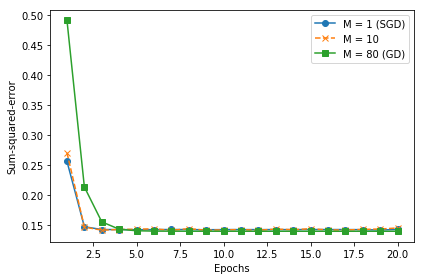

Model of M = 1 (SGD) :
Misclassified samples: 1
Accuracy: 0.95

Model of M = 10 :
Misclassified samples: 1
Accuracy: 0.95

Model of M = 80 (GD) :
Misclassified samples: 1
Accuracy: 0.95


In [48]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

adas_m1 = AdaMiniBatchGD(batch_size = 1, n_iter=20, eta=0.01, random_state=1)
adas_m1.fit(X_train_std, y_train)

adas_m2 = AdaMiniBatchGD(batch_size = 10, n_iter=20, eta=0.01, random_state=1)
adas_m2.fit(X_train_std, y_train)

adas_m3 = AdaMiniBatchGD(batch_size = 80, n_iter=20, eta=0.01, random_state=1)
adas_m3.fit(X_train_std, y_train)


# cost values

plt.plot(range(1, len(adas_m1.cost_) + 1), adas_m1.cost_, 
         marker='o', label='M = 1 (SGD)')
plt.plot(range(1, len(adas_m2.cost_) + 1), adas_m2.cost_, 
         marker='x', linestyle='--', label='M = 10')
plt.plot(range(1, len(adas_m3.cost_) + 1), adas_m3.cost_, 
         marker='s', label='M = 80 (GD)')

plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred_m1 = adas_m1.predict(X_test_std)
y_pred_m2 = adas_m2.predict(X_test_std)
y_pred_m3 = adas_m3.predict(X_test_std)

print('Model of M = 1 (SGD) :')
print('Misclassified samples: %d' % (y_test != y_pred_m1).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_m1))

print('\nModel of M = 10 :')
print('Misclassified samples: %d' % (y_test != y_pred_m2).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_m2))

print('\nModel of M = 80 (GD) :')
print('Misclassified samples: %d' % (y_test != y_pred_m3).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_m3))